## Libs



In [1]:
import json
import joblib
# Manipulação e análise de dados
import pandas as pd
import numpy as np
from collections import Counter

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# NLP e pré-processamento
import re
import spacy

# Vetorização de texto
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelagem
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Balanceamento
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline

In [2]:
!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 94.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Carregar conjuntos

In [3]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').squeeze()  # transforma em Series
y_test = pd.read_csv('y_test.csv').squeeze()

## Otimização de Hiperparâmetros — Random Forest com Pipeline + SMOTE + GridSearchCV


In [4]:
pipeline_rf = Pipeline([
    ('smote', SMOTE(random_state=1995)),
    ('clf', RandomForestClassifier(random_state=1995))
])

param_grid_rf = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2'],
    'clf__class_weight': ['balanced', None]
}

grid_rf = GridSearchCV(
    pipeline_rf,
    param_grid=param_grid_rf,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)
print("Melhores parâmetros RF:", grid_rf.best_params_)
y_pred_rf = grid_rf.predict(X_test)
print("=== Random Forest com SMOTE ===")
print(classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Melhores parâmetros RF: {'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
=== Random Forest com SMOTE ===
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     15232
           1       0.16      0.52      0.25       896

    accuracy                           0.82     16128
   macro avg       0.56      0.68      0.57     16128
weighted avg       0.92      0.82      0.86     16128



## Otimização de Hiperparâmetros —  Regressão Logística com Pipeline + SMOTE + GridSearchCV

In [5]:
pipeline_lr = Pipeline([
    ('smote', SMOTE(random_state=1995)),
    ('clf', LogisticRegression(random_state=1995, max_iter=2000))
])

param_grid_lr = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga'],
    'clf__class_weight': ['balanced', None]
}

grid_lr = GridSearchCV(
    pipeline_lr,
    param_grid=param_grid_lr,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train, y_train)
print("Melhores parâmetros LR:", grid_lr.best_params_)
y_pred_lr = grid_lr.predict(X_test)
print("=== Regressão Logística com SMOTE ===")
print(classification_report(y_test, y_pred_lr))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Melhores parâmetros LR: {'clf__C': 0.01, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
=== Regressão Logística com SMOTE ===
              precision    recall  f1-score   support

           0       0.97      0.76      0.85     15232
           1       0.12      0.59      0.21       896

    accuracy                           0.75     16128
   macro avg       0.55      0.67      0.53     16128
weighted avg       0.92      0.75      0.81     16128



## Otimização de Hiperparâmetros — XGBoost com Pipeline + SMOTE + GridSearchCV



In [6]:
pipeline_xgb = Pipeline([
    ('smote', SMOTE(random_state=1995)),
    ('clf', XGBClassifier(random_state=1995, use_label_encoder=False, eval_metric='logloss'))
])

param_grid_xgb = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.3],
    'clf__subsample': [0.8, 1],
    'clf__colsample_bytree': [0.8, 1],
    'clf__scale_pos_weight': [1, 5, 10]
}

grid_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train)
print("Melhores parâmetros XGBoost:", grid_xgb.best_params_)
y_pred_xgb = grid_xgb.predict(X_test)
print("=== XGBoost com SMOTE ===")
print(classification_report(y_test, y_pred_xgb))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:10:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores parâmetros XGBoost: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 1, 'clf__subsample': 0.8}
=== XGBoost com SMOTE ===
              precision    recall  f1-score   support

           0       0.97      0.82      0.88     15232
           1       0.14      0.53      0.23       896

    accuracy                           0.80     16128
   macro avg       0.56      0.67      0.56     16128
weighted avg       0.92      0.80      0.85     16128



## Salvar os modelos (após o fit)

In [7]:
joblib.dump(grid_rf.best_estimator_, 'modelo_melhor_rf.pkl')
joblib.dump(grid_lr.best_estimator_, 'modelo_melhor_lr.pkl')
joblib.dump(grid_xgb.best_estimator_, 'modelo_melhor_xgb.pkl')


['modelo_melhor_xgb.pkl']

**Diagnóstico resumido**

| Modelo                  | Recall da classe 1 | F1 da classe 1 | Accuracy |
| ----------------------- | ------------------ | -------------- | -------- |
| **Random Forest**       | 0.52               | 0.25           | 0.82     |
| **Logistic Regression** | 0.59               | 0.21           | 0.75     |
| **XGBoost**             | 0.53               | 0.23           | 0.81     |


 ### Gerar métricas para diferentes thresholds

In [8]:
# Gerar probabilidades da classe positiva (classe 1)
y_proba_rf = grid_rf.predict_proba(X_test)[:, 1]

# Gerar lista de thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
relatorios = []

# Avaliar cada threshold
for t in thresholds:
    y_pred = (y_proba_rf >= t).astype(int)
    report = classification_report(y_test, y_pred, output_dict=True)
    relatorios.append({
        'threshold': t,
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_1': report['1']['f1-score'],
        'accuracy': report['accuracy']
    })
df_resultados = pd.DataFrame(relatorios)
df_resultados

,threshold,precision_1,recall_1,f1_1,accuracy
0,0.10,0.074141,0.919643,0.137219,0.357515
1,0.15,0.085518,0.859375,0.155556,0.481647
2,0.20,0.096104,0.784598,0.171234,0.578063
3,0.25,0.108295,0.734375,0.188755,0.649306
4,0.30,0.117077,0.674107,0.199505,0.699467
5,0.35,0.127019,0.640625,0.212004,0.735429
6,0.40,0.135128,0.588170,0.219766,0.767981
7,0.45,0.144889,0.545759,0.228986,0.795821
8,0.50,0.160665,0.517857,0.245243,0.822917
9,0.55,0.178646,0.479911,0.260369,0.848524


### Visualizando desempenho por threshold

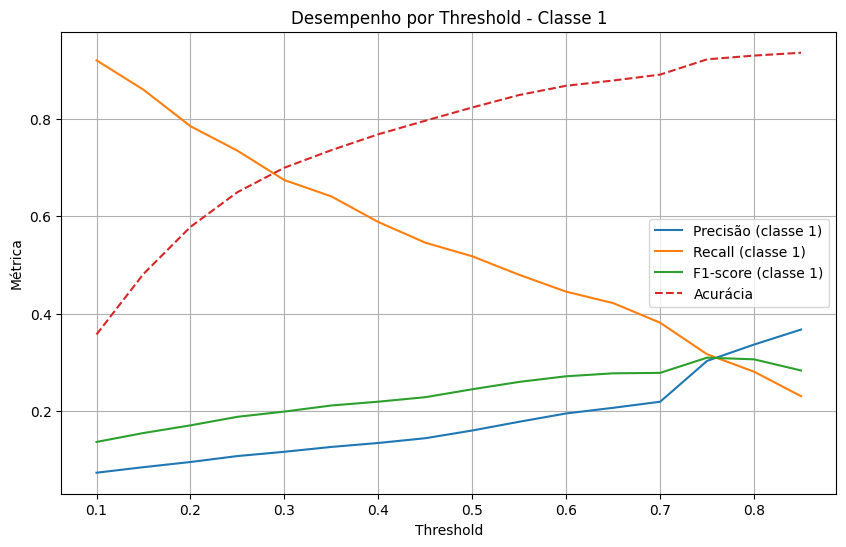

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(df_resultados['threshold'], df_resultados['precision_1'], label='Precisão (classe 1)')
plt.plot(df_resultados['threshold'], df_resultados['recall_1'], label='Recall (classe 1)')
plt.plot(df_resultados['threshold'], df_resultados['f1_1'], label='F1-score (classe 1)')
plt.plot(df_resultados['threshold'], df_resultados['accuracy'], label='Acurácia', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Métrica')
plt.title('Desempenho por Threshold - Classe 1')
plt.legend()
plt.grid(True)
plt.show()

### Melhor threshold

In [10]:
# Melhor threshold com base no F1 da classe 1
melhor_linha = df_resultados.loc[df_resultados['f1_1'].idxmax()]
melhor_threshold = melhor_linha['threshold']

print(f"Melhor threshold (F1 classe 1): {melhor_threshold:.2f}")
y_pred_final = (y_proba_rf >= melhor_threshold).astype(int)
print(classification_report(y_test, y_pred_final))

Melhor threshold (F1 classe 1): 0.75
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     15232
           1       0.30      0.32      0.31       896

    accuracy                           0.92     16128
   macro avg       0.63      0.64      0.63     16128
weighted avg       0.92      0.92      0.92     16128



### Salvar modelo final com threshold ajustado

In [11]:
# Salvar modelo treinado
joblib.dump(grid_rf.best_estimator_, 'modelo_rf_final.pkl')

# Salvar threshold ideal
with open('threshold_ideal.txt', 'w') as f:
    f.write(str(melhor_threshold))  # exemplo: 0.75